# Unbuffered backtest

In [21]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf   # falls back to sample cov below

EXCHANGE_NAME = 'binance' 

paths = {
	"binance": "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv",
	"bybit": "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv",
	"hyperliquid": "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv",
	"paradex": "/Users/ilyat/Documents/quant📈/ccxt_data/data/paradex/ohlc/perps/combined.csv",
}

df = pd.read_csv(paths[EXCHANGE_NAME])
df = df.sort_values(by=['timestamp'])
first_idx = df['fundingRate'].first_valid_index() # important to see when stuff began trading
df = df.loc[first_idx:]
df = df[df.timestamp<'2025-01-01']
df = df[df.timestamp>'2021-01-01']

In [22]:
import json
# Filter out stablecoins
with open('./ready_strategies/stablecoins.json', 'r') as f:
	stablecoin_symbols = json.load(f)

print(f"Loaded {len(stablecoin_symbols)} stablecoins from JSON file.")
before_filter = df['symbol'].unique()
df = df[~df['symbol'].isin(stablecoin_symbols)]
after_filter = df['symbol'].unique()
print(f"Filtered out {len(before_filter) - len(after_filter)} stablecoins.")

Loaded 250 stablecoins from JSON file.
Filtered out 2 stablecoins.


In [23]:
df.columns

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'long_liquidation_volume', 'short_liquidation_volume',
       'buy_volume_ratio', 'Buy_Trades', 'Total_Trades'],
      dtype='object')

In [24]:
import ready_strategies.signals as signals
# Constants
trading_cost_rate = 15e-4
top_n = 50 # we use top_n coins by dollar volume
post_date = False
filter_date = '2024-01-01'
portfolio_l2_norm = 0.0
weight_inertia = 0.3
vol_target_bool = False
vol_target_ann=0.20
cov_lookback=90
universe_filter_variable = "dollar_volume_slowed"
# universe_filter_variable = "market_cap_slowed"

#print parameters
print(f"Exchange: {EXCHANGE_NAME}")
print(f"Top N: {top_n}")
print(f"Portfolio L2 norm: {portfolio_l2_norm}")


Exchange: binance
Top N: 50
Portfolio L2 norm: 0.0


In [25]:
# Signal generation
def compute_signal(df_filtered: pd.DataFrame) -> pd.DataFrame:
	signal_names = ['xs_bolmom', 'xs_buy_volume', 'liquidation_imbalance', 'ls_ratio']
	for sn in signal_names:
		df_filtered = signals.compute_signal(df_filtered, sn, True)

	return df_filtered

# ── Universe filtering ──────────────────────────────────────────────────────
def filter_universe(df: pd.DataFrame,
                    top_n:   int,
                    min_obs: int = 60          # e.g. require 60 trading-day history
                   ) -> pd.DataFrame:
    """
    Keep rows whose
        • symbol has ≥ `min_obs` observations up to that date, *then*
        • symbol is in the top-`top_n` by `dollar_volume_slowed`
          **among those eligible names**.

    This guarantees exactly `top_n` names whenever that many are available.
    """
    df = df.copy()

    # 1) how many observations each symbol has accumulated up to *and incl.* the row
    df['obs_cnt'] = df.groupby('symbol').cumcount() + 1

    # 2) Boolean flag: does the row meet the look-back requirement?
    df['eligible'] = df['obs_cnt'] >= min_obs

    # 3) Rank *only* the eligible rows at each timestamp
    eligible_mask = df['eligible']
    df.loc[eligible_mask, 'filter_rank_avail'] = (
        df.loc[eligible_mask]
          .groupby('timestamp')[universe_filter_variable]
          .rank(method='first', ascending=False)
    )

    # 4) Final selection: top-N among the eligible set
    mask = df['filter_rank_avail'].le(top_n)

    return (
        df.loc[mask]
          .drop(columns=['obs_cnt', 'eligible', 'filter_rank_avail'])
    )


# Utility functions
def winsorize(x):
	"""Winsorize series at 5th and 95th percentiles."""
	return np.clip(x, x.quantile(0.025), x.quantile(0.975))

# Data preparation
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
	df = df.sort_values(['timestamp', 'symbol'])
	df['return'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change())

	# 1) Calculate volatility
	df['vol_expanding_window'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .expanding(min_periods=30)
					  .std())
	)
	df['vol_ewm'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .ewm(span=30, adjust=False, min_periods=30)
					  .std())
	)
	df['volatility'] = (
		df['vol_expanding_window'] * 0.25 +
		df['vol_ewm'] * 0.75
	)

	# 2) filter universe
	df['dollar_volume'] = df['close'] * df['volume']
	df['dollar_volume_slowed'] = (
		df.groupby('symbol')['dollar_volume']
		  .transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['dv_rank'] = (
		df.groupby('timestamp')['dollar_volume_slowed']
		  .rank(method='first', ascending=False)
		  .fillna(1000000)
		  .astype(int)
	)

	df['market_cap_slowed'] = (
	df.groupby('symbol')['market_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['mc_rank'] = (
		df.groupby('timestamp')['market_cap_slowed']
			.rank(method='first', ascending=False)
			.fillna(1000000)
			.astype(int)
	)

	return df

# Pivot for backtest inputs
def pivot_data(df: pd.DataFrame):
	signal = df.pivot(index='timestamp', columns='symbol', values='signal')
	returns = df.pivot(index='timestamp', columns='symbol', values='return')
	funding = df.pivot(index='timestamp', columns='symbol', values='fundingRate')
	volatility = df.pivot(index='timestamp', columns='symbol', values='volatility')

	return signal, returns, funding, volatility

def compute_weights(signal: pd.DataFrame,
                    lag: bool = True,
                    lam_l2: float = 0.0,
                    inertia: float = 0.0     # 0 ≤ inertia < 1
                   ) -> pd.DataFrame:
    """
    Convert a cross-sectional alpha signal into dollar-neutral weights.

    Parameters
    ----------
    signal   : DataFrame  (index = timestamp, columns = symbol)
    lag      : bool       shift weights by one bar to avoid look-ahead
    lam_l1   : float      L¹ turnover penalty   (0 = off)
    lam_l2   : float      L² shrinkage penalty  (0 = off)
    inertia  : float      fraction of yesterday’s book to keep
                           0 → no decay (default, original behaviour)
                           0.6 → keep 60 % of prev. weights
    """
    # 1) Demean signal
    adj = signal.sub(signal.mean(axis=1), axis=0)

    # 3) L² shrinkage penalty
    if lam_l2:
        adj = adj / (1 + lam_l2 * (adj**2))

    # 4) Dollar-neutral, |w| = 1
    weights_raw = adj.sub(adj.mean(axis=1), axis=0)
    weights_raw = weights_raw.div(weights_raw.abs().sum(axis=1), axis=0)

    # 5) Optional inertia (weight decay)
    if inertia:
        prev_w   = weights_raw.shift(1).fillna(0.0)
        weights  = inertia * prev_w + (1 - inertia) * weights_raw
    else:
        weights  = weights_raw

    # 6) Optional one-bar lag
    if lag:
        weights = weights.shift(1)

    return weights.fillna(0.0)

def vol_target_weights(raw_w: pd.DataFrame,
                       rets:   pd.DataFrame,
                       vol_target_ann: float = 0.10,   # 10 % annualised
                       lookback: int      = 130,        # trading days
                       min_obs:  int      = 40) -> pd.DataFrame:
    """
    Scale each day's weight vector so that realised σ ≈ `vol_target_ann`
    when estimated with a Ledoit-Wolf covariance on the past `lookback` days.

    Parameters
    ----------
    raw_w            : DataFrame (index = timestamp, columns = symbol)
                       *pre-leverage* weights (dollar-neutral & |w|=1 already)
    rets             : DataFrame, same shape/order as `raw_w`
    vol_target_ann   : float, annualised target volatility (e.g. 0.10 = 10 %)
    lookback         : int, size of rolling window (calendar rows) for Σ̂
    min_obs          : int, minimum obs to start scaling; before that w = raw_w

    Returns
    -------
    scaled_w         : DataFrame of leverage-adjusted weights
    """
    # daily target σ
    tgt_daily = vol_target_ann / np.sqrt(365)

    scaled = []
    for t, w in raw_w.iterrows():
        # slice past window *strictly up to and excluding* t
        end_loc = rets.index.get_loc(t)
        win = rets.iloc[max(0, end_loc - lookback): end_loc]
        win = win.dropna(axis=1, how="all").ffill()    

        if len(win) < min_obs:
            scaled.append(w)                     # not enough history yet
            continue

        # drop cols that are all-nan in window to keep LedoitWolf happy
        win = win.loc[:, win.notna().any()]

        # if every weight is zero (all skipped universe) just keep it
        if np.allclose(w, 0):
            scaled.append(w.reindex(raw_w.columns).fillna(0))
            continue

        # Ledoit–Wolf shrinkage; fall back if sklearn missing
        try:
            lw = LedoitWolf().fit(win.fillna(0))
            Sigma = lw.covariance_
            Sigma = pd.DataFrame(Sigma, index=win.columns, columns=win.columns)
        except Exception:
            Sigma = win.cov().fillna(0)

        # align Σ to full column set, fill missing with zeros
        Sigma = Sigma.reindex(index=raw_w.columns, columns=raw_w.columns).fillna(0)

        # portfolio variance and scaling factor
        var_p = np.dot(w.values, np.dot(Sigma.values, w.values))
        if var_p <= 0:
            scale = 0.0
        else:
            scale = tgt_daily / np.sqrt(var_p)

        scaled.append(w * scale)

    scaled_w = pd.DataFrame(scaled, index=raw_w.index).fillna(0.0)
    return scaled_w

# PnL and turnover calculation
def backtest(weights: pd.DataFrame,
			 returns: pd.DataFrame,
			 funding: pd.DataFrame,
			 cost_rate: float):
	weights = weights.fillna(0)
	return_pnl = (weights * returns).sum(axis=1)
	funding_pnl = -(weights * funding).sum(axis=1)
	total = return_pnl + funding_pnl
	turnover = weights.fillna(0).diff().abs().sum(axis=1)
	total_after_cost = total - cost_rate * turnover
	return return_pnl, funding_pnl, total_after_cost, turnover

# ── Nicer-looking equity plot ────────────────────────────────────────────────
def plot_results(return_pnl, funding_pnl, total_after_cost):
    """
    Four equity curves, uniform line weight, color-blind friendly palette.
    """
    import matplotlib.pyplot as plt

    # cumulative equity series (constant GMV, start = 1.0)
    gross_eq   = 1 + (return_pnl + funding_pnl).cumsum()
    total_eq   = 1 + total_after_cost.cumsum()
    return_eq  = 1 + return_pnl.cumsum()
    funding_eq = 1 + funding_pnl.cumsum()

    plt.figure(figsize=(14, 6))

    # color-blind friendly hues
    palette = {
        "gross"  : "#E15759",   # muted red
        "net"    : "#4E4E4E",   # dark grey / near-black
        "return" : "#3B8EE5",   # blue
        "funding": "#47B39C"    # teal-green
    }

    lw = 2.2       # consistent thickness
    gross_eq.plot  (label="Gross Equity (no costs)",      lw=lw, ls="--", color=palette["gross"])
    total_eq.plot  (label="Net Equity (constant GMV)",    lw=lw,           color=palette["net"])
    return_eq.plot (label="Price-Return Equity",          lw=lw,           color=palette["return"])
    funding_eq.plot(label="Funding Equity",               lw=lw,           color=palette["funding"])

    plt.title("Equity Curves – Constant GMV")
    plt.xlabel("Date")
    plt.ylabel("Equity (start = 1.0)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ── Expanded performance report ──────────────────────────────────────────────
def report_metrics(total_after_cost, return_pnl, turnover, cost_rate):
    """
    Prints an extended performance summary.
    """
    import numpy as np
    import pandas as pd

    # --- core statistics -----------------------------------------------------
    mu     = total_after_cost.mean()
    sigma  = return_pnl.std()
    sharpe = mu / sigma * np.sqrt(365)

    # 95 % CI on annualised Sharpe (Jobson & Korkie, 1981)
    n   = len(total_after_cost)
    se  = np.sqrt((1 + 0.5 * sharpe**2) * 365 / n)
    ci  = sharpe - 1.96 * se, sharpe + 1.96 * se

    # --- risk-adjusted extras -----------------------------------------------
    # annualised volatility
    vol_ann = sigma * np.sqrt(365) * 100

    # CAGR of the equity curve (constant-GMV arithmetic cum-P&L)
    equity_curve = 1 + total_after_cost.cumsum()
    cagr = equity_curve.iloc[-1]**(365 / n) - 1

    # max drawdown of cumulative P&L (not compounded)
    running_max = equity_curve.cummax()
    drawdown    = equity_curve - running_max
    max_dd      = drawdown.min()      # negative number

    # turnover & cost
    avg_turnover   = turnover.mean()
    avg_hold       = 1 / avg_turnover if avg_turnover else np.inf
    cost_pnl       = -cost_rate * turnover
    cost_drag_bps  = cost_pnl.mean() * 1e4* 365   # annual cost in bps

    # --- print nicely --------------------------------------------------------
    print("──────── Performance Summary ────────")
    print(f"CAGR:                          {cagr:7.2%}")
    print(f"Annualised volatility:         {vol_ann:7.2f}%")
    print(f"Sharpe (ann.):                 {sharpe:7.2f}   95% CI [{ci[0]:.2f}, {ci[1]:.2f}]")
    print(f"Max drawdown:                 {max_dd:8.2%}")
    print("──────── Execution / Cost ───────────")
    print(f"Avg daily turnover:            {avg_turnover:7.2%}")
    print(f"Avg holding period:            {avg_hold:7.2f} days")
    print(f"Average annual cost drag:       {cost_drag_bps:7.2f} bp")


data = prepare_data(df)
# calculate target
data['target'] = data.groupby('symbol')['close'].transform(lambda x: (x.shift(-5) / x) - 1)
data['target'] = data.groupby('timestamp')['target'].transform(lambda x: x-x.mean())
data = data.dropna(subset=['target'])
with_signal = compute_signal(data)
universe = filter_universe(with_signal, top_n)


Computing Bollinger Band momentum signal...
Computing buy volume ratio signal...
Computing liquidation imbalance signal...
Computing long–short ratio signal...


                              non_null_count  total_count  completeness_pct
symbol                                 69800        69800          1.000000
timestamp                              69800        69800          1.000000
open                                   69800        69800          1.000000
high                                   69800        69800          1.000000
low                                    69800        69800          1.000000
close                                  69800        69800          1.000000
volume                                 69800        69800          1.000000
market_cap                             64438        69800          0.923181
fundingRate                            68364        69800          0.979427
oi                                     66642        69800          0.954756
ls_ratio                               67722        69800          0.970229
longs_pct                              67722        69800          0.970229
long_liquida

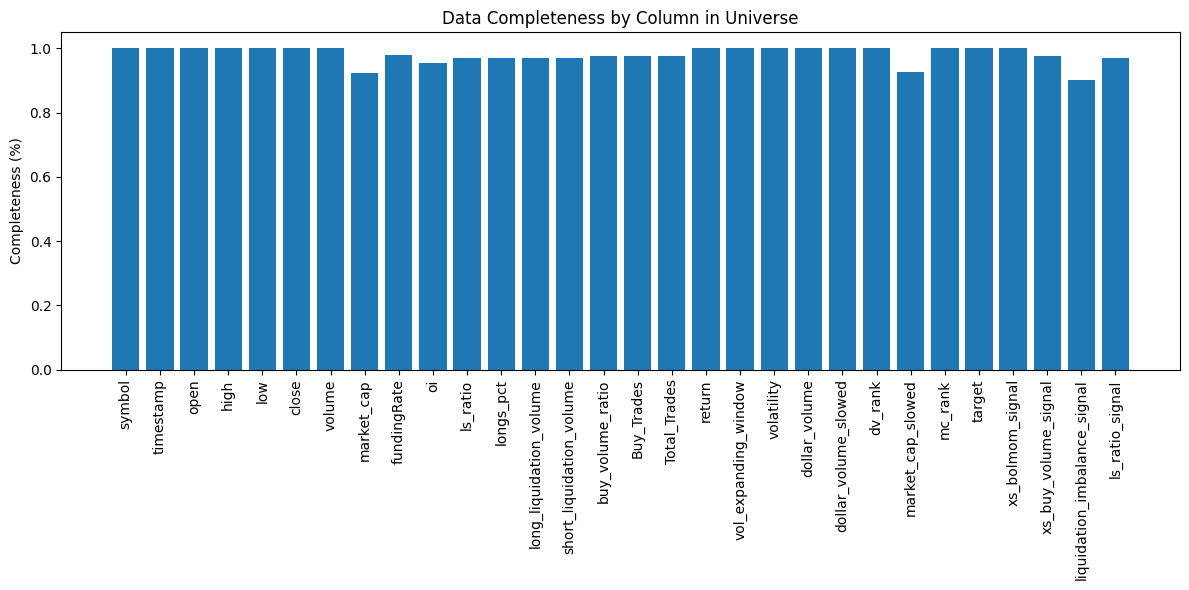

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute completeness metrics
completeness = pd.DataFrame({
    'non_null_count': universe.notnull().sum(),
    'total_count': len(universe)
})
completeness['completeness_pct'] = completeness['non_null_count'] / completeness['total_count']

# Display the completeness table
print(completeness)

# Plot completeness percentages
plt.figure(figsize=(12, 6))
plt.bar(completeness.index, completeness['completeness_pct'])
plt.xticks(rotation=90)
plt.ylabel('Completeness (%)')
plt.title('Data Completeness by Column in Universe')
plt.tight_layout()
plt.show()


In [27]:
universe

,symbol,timestamp,open,high,low,close,volume,market_cap,fundingRate,oi,...,dollar_volume,dollar_volume_slowed,dv_rank,market_cap_slowed,mc_rank,target,xs_bolmom_signal,xs_buy_volume_signal,liquidation_imbalance_signal,ls_ratio_signal
18620,1INCH,2021-03-02,4.01380,4.33040,3.98280,4.06790,23118130.0,5.754425e+08,0.000310,NaN,...,9.404224e+07,1.434543e+08,22,4.348451e+08,51,-0.036293,0.084982,0.462671,-0.000751,-6.6746
18640,AAVE,2021-03-02,391.50900,420.14000,383.98900,396.55100,397737.7,4.643676e+09,0.000587,NaN,...,1.577233e+08,2.029343e+08,15,3.966496e+09,12,0.002074,0.207523,0.483367,0.000086,-3.2535
18624,ADA,2021-03-02,1.22288,1.26997,1.20786,1.21399,597127511.0,4.030911e+10,0.000300,NaN,...,7.249068e+08,1.033055e+09,5,2.124008e+10,3,-0.178554,0.650369,0.475379,NaN,-5.2933
18634,ALGO,2021-03-02,1.08380,1.23670,1.05880,1.18030,109791479.1,2.200547e+09,0.000508,NaN,...,1.295869e+08,8.549136e+07,35,1.402583e+09,30,-0.120185,0.358417,0.468788,0.000038,-6.2098
18625,ALPHA,2021-03-02,1.51415,1.93326,1.48385,1.83116,80982423.0,2.423778e+08,0.000643,NaN,...,1.482918e+08,9.145484e+07,34,2.276547e+08,59,-0.216460,0.304876,0.465378,0.000662,-1.3607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271161,UXLINK,2024-12-26,2.01900,2.06380,1.81560,1.87180,431687244.0,4.068323e+08,-0.089013,5.262542e+07,...,8.080322e+08,5.156866e+08,20,1.330892e+08,186,-0.237637,1.000000,0.487827,0.003170,-2.0111
271286,WIF,2024-12-26,1.83910,1.93470,1.79640,1.82660,162866076.4,2.007983e+09,0.000300,1.349027e+08,...,2.974912e+08,7.431084e+08,13,2.725609e+09,33,0.003934,-0.596416,0.483703,-0.000284,-4.3735
271188,WLD,2024-12-26,2.18530,2.31080,2.15570,2.18530,113607066.0,NaN,0.000300,1.109670e+08,...,2.482655e+08,5.387185e+08,19,0.000000e+00,293,0.005935,-0.188257,0.480764,-inf,-5.2228
271385,XLM,2024-12-26,0.35453,0.36901,0.34433,0.34970,432827212.0,1.173600e+10,0.000298,4.427708e+07,...,1.513597e+08,5.957811e+08,16,1.004116e+10,12,0.203753,0.209276,0.489624,-0.000018,-2.3546


In [28]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from numpy.linalg import LinAlgError
# import matplotlib.pyplot as plt


# def add_ols_forecasts(
#     universe: pd.DataFrame,
#     lookback: int = 365,       # training window
#     refit_every: int = 30,     # refit cadence
#     signals: list = [
#         'xs_bolmom_signal',
#         'xs_buy_volume_signal',
#         'liquidation_imbalance_signal'
#     ],
#     target_col: str = 'target'
# ) -> tuple[pd.DataFrame, pd.DataFrame]:
#     """
#     Walk-forward zero-intercept OLS.
#     • β is updated every `refit_every` days using a `lookback` window.
#     • On non-refit days, forecast = LAST_β × TODAY'S signal  (so it moves daily).
#     Returns:
#       out        – universe with forecast_<signal> and forecast_meta columns
#       betas_df   – rolling β time-series
#     """
#     df = universe.copy()
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     dates = sorted(df['timestamp'].unique())
#     syms  = df['symbol'].unique()

#     # Wide matrices
#     pivot_T = df.pivot(index='timestamp', columns='symbol', values=target_col).reindex(dates)
#     pivot_S = {s: df.pivot(index='timestamp', columns='symbol', values=s).reindex(dates)
#                for s in signals}

#     # Containers
#     fcst      = {s: pd.DataFrame(index=dates, columns=syms, dtype=float) for s in signals}
#     fcst['meta'] = pd.DataFrame(index=dates, columns=syms, dtype=float)
#     betas_df  = pd.DataFrame(index=dates, columns=signals, dtype=float)

#     # Keep track of most-recent β for each signal
#     current_beta = {s: np.nan for s in signals}

#     for i, today in enumerate(dates):
#         # skip until we have enough history
#         if i < lookback:
#             continue

#         # --- Refit step ------------------------------------------------------
#         if (i - lookback) % refit_every == 0:
#             train_dates = dates[i - lookback : i]
#             Y_train = pivot_T.loc[train_dates]

#             for s in signals:
#                 xt = pivot_S[s].loc[train_dates].stack()
#                 yt = Y_train.stack().reindex(xt.index)
#                 df_xy = (
#                     pd.DataFrame({'x': xt, 'y': yt})
#                       .replace([np.inf, -np.inf], np.nan)
#                       .dropna()
#                 )
#                 if len(df_xy) < 50:
#                     continue

#                 try:
#                     beta = sm.OLS(df_xy['y'], df_xy['x']).fit().params[0]
#                     current_beta[s] = beta
#                 except (LinAlgError, ValueError):
#                     continue

#         # --- Daily forecast using latest β -----------------------------------
#         preds_today = {}
#         for s in signals:
#             beta = current_beta[s]
#             if pd.isna(beta):
#                 continue
#             preds_today[s] = beta * pivot_S[s].loc[today]
#             fcst[s].iloc[i] = preds_today[s]
#             betas_df.at[today, s] = beta

#         # Meta forecast = mean of available individual forecasts
#         if preds_today:
#             meta = pd.DataFrame(preds_today).T.mean(axis=0)
#             fcst['meta'].iloc[i] = meta

#     # ------------------------------------------------------------------------
#     # Merge forecasts back to narrow form
#     out = df.copy()
#     for s in signals:
#         col = f"forecast_{s.replace('_signal','')}"
#         out = out.merge(
#             fcst[s].stack().rename(col).reset_index()
#                     .rename(columns={'level_0':'timestamp','level_1':'symbol'}),
#             on=['timestamp','symbol'], how='left'
#         )

#     # meta
#     out = out.merge(
#         fcst['meta'].stack().rename('signal').reset_index()
#                     .rename(columns={'level_0':'timestamp','level_1':'symbol'}),
#         on=['timestamp','symbol'], how='left'
#     )

#     return out, betas_df


# # === USAGE & QUICK PLOT ======================================================
# universe_fc, betas_df = add_ols_forecasts(universe)

# for sig in betas_df.columns:
#     series = betas_df[sig].dropna()
#     if series.empty:
#         continue
#     plt.figure(figsize=(10,4))
#     plt.plot(series.index, series.values)
#     plt.title(f"Rolling β – {sig}")
#     plt.xlabel("Date"); plt.ylabel("β")
#     plt.tight_layout(); plt.show()


In [29]:
universe[universe.symbol=='BTC']['liquidation_imbalance_signal']

18665              NaN
18711              NaN
18862              NaN
18899              NaN
18973              NaN
              ...     
269812   -4.857868e-06
270159   -3.388725e-06
270458   -6.793509e-07
270984   -9.476627e-08
271201   -7.988515e-07
Name: liquidation_imbalance_signal, Length: 1396, dtype: float64

In [30]:
# standardize signals for ridge regression
signals = [
	'xs_bolmom_signal',
	'xs_buy_volume_signal',
	'ls_ratio',
	'liquidation_imbalance_signal'
]
universe[signals] = (
    universe
    .groupby('timestamp')[signals]
    .transform(lambda x: (x - x.mean()) / x.std())
    .fillna(0)        # optional: turn any NaNs (from zero‐std days) into 0
	.clip(-3,3)
)

/Users/ilyat/finance-venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ilyat/finance-venv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


<Axes: >

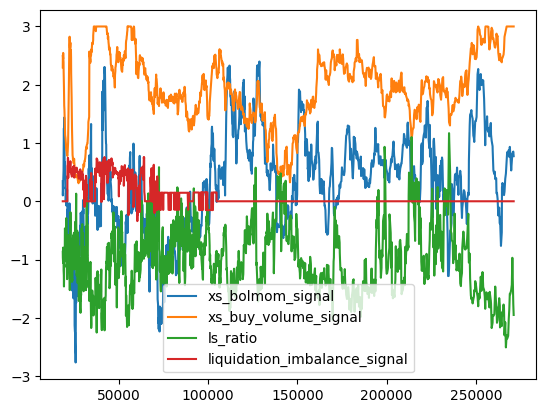

In [31]:
universe[universe.symbol=='BTC'][signals].plot()

/Users/ilyat/finance-venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/Users/ilyat/finance-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ilyat/finance-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ilyat/finance-venv/lib/python3.10/site-

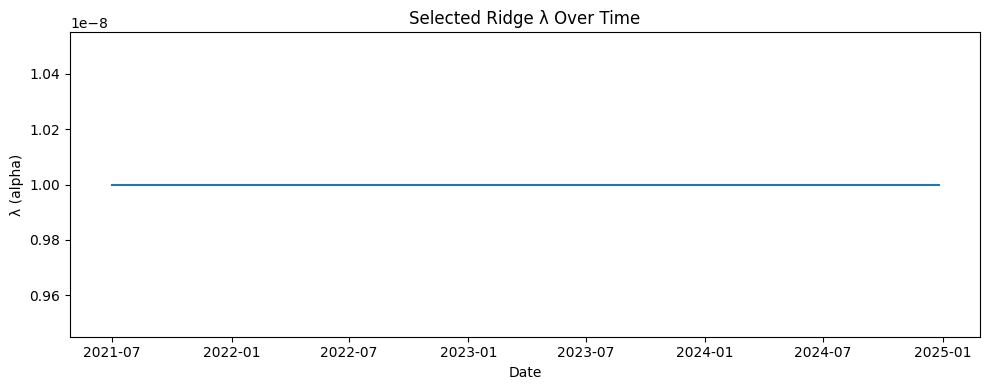

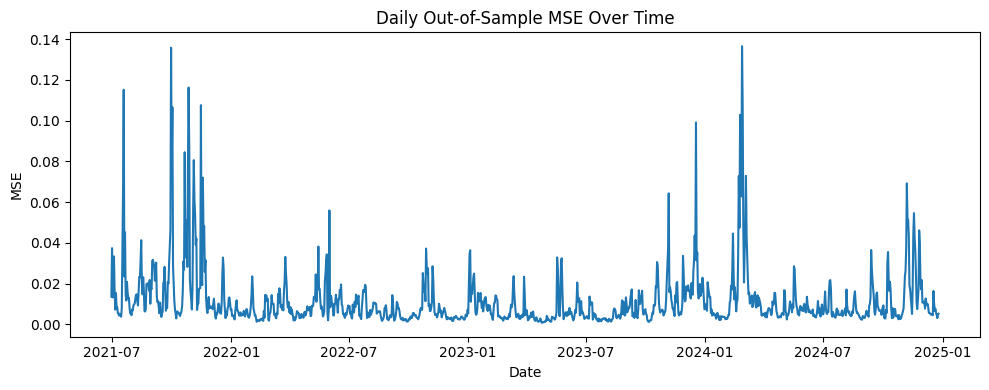

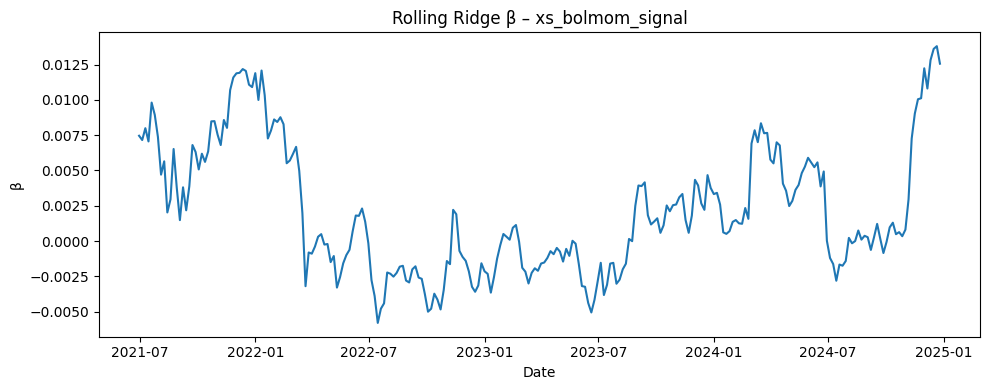

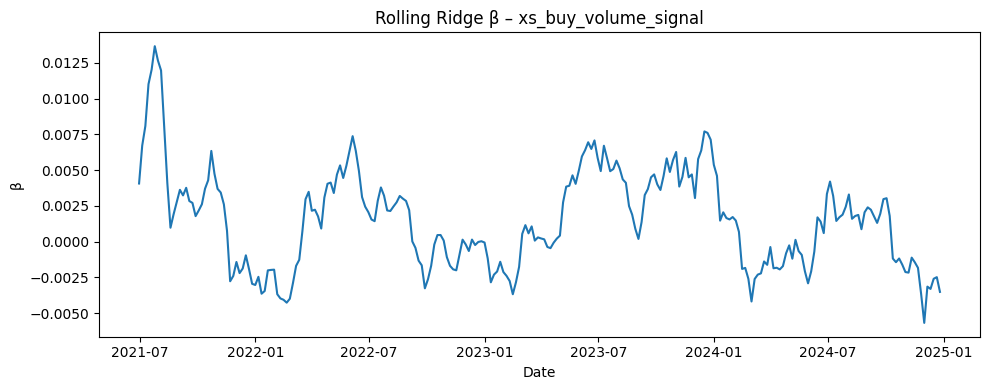

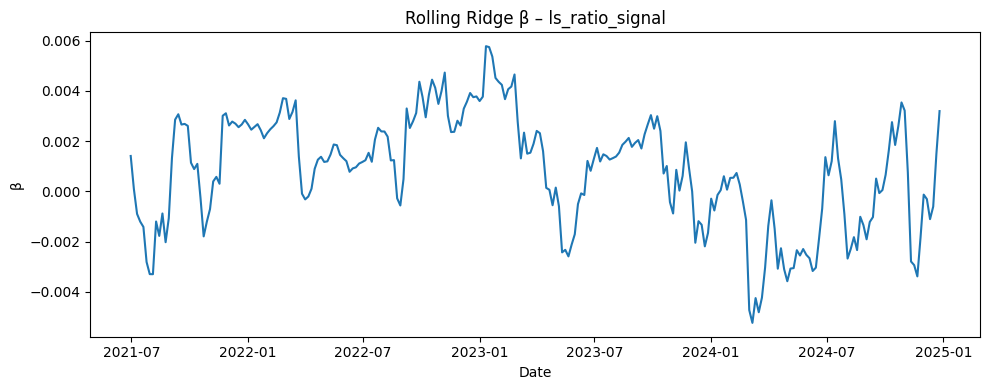

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from numpy.linalg import LinAlgError
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

def add_ridge_cv_forecasts(
    universe: pd.DataFrame,
    lookback: int = 120,
    refit_every: int = 5,
    signals: list = [
        'xs_bolmom_signal',
        'xs_buy_volume_signal',
        'ls_ratio_signal'
    ],
    target_col: str = 'target',
    n_splits: int = 5,
    purge_days: int = 5,
    alphas: np.ndarray = np.logspace(-8, 2, 25)
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Walk‐forward ridge with purged CV combining all signals, returning:
      - out:         universe + 'signal' forecast column
      - betas_df:    rolling ridge coefficients
      - lambda_ser:  chosen alpha each refit day
      - mse_ser:     daily out‐of‐sample MSE of forecast vs target
    """
    df = universe.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    dates = sorted(df['timestamp'].unique())
    syms  = df['symbol'].unique()

    # build wide‐form targets and signals
    pivot_T = df.pivot(index='timestamp', columns='symbol', values=target_col).reindex(dates)
    pivot_S = {s: df.pivot(index='timestamp', columns='symbol', values=s).reindex(dates)
               for s in signals}

    # prepare containers
    fcst_meta   = pd.DataFrame(index=dates, columns=syms, dtype=float)
    betas_df    = pd.DataFrame(index=dates, columns=signals, dtype=float)
    lambda_ser  = pd.Series(index=dates, dtype=float)
    mse_ser     = pd.Series(index=dates, dtype=float)
    current_beta  = {s: np.nan for s in signals}
    current_alpha = np.nan

    for i, today in enumerate(dates):
        # skip until enough lookback
        if i < lookback:
            continue

        # refit on rolling window every `refit_every` days
        if (i - lookback) % refit_every == 0:
            train_dates = dates[i - lookback : i]

            # stack into long form
            X_list = [pivot_S[s].loc[train_dates].stack().rename(s) for s in signals]
            Xw = pd.concat(X_list, axis=1)
            y  = pivot_T.loc[train_dates].stack().rename('y')
            df_xy = (
                Xw.join(y, how='inner')
                  .replace([np.inf, -np.inf], np.nan)
                  .dropna()
            )

            # only fit if enough data
            if len(df_xy) >= len(signals) * 10:
                # build purged time‐series CV folds
                unique_dates = df_xy.index.get_level_values(0).unique()
                date_splits = np.array_split(unique_dates, n_splits)
                splits = []
                for test_dates in date_splits:
                    test_mask = df_xy.index.get_level_values(0).isin(test_dates)
                    test_idx  = np.flatnonzero(test_mask)
                    purge_cutoff = test_dates.min() - pd.Timedelta(days=purge_days)
                    train_mask = df_xy.index.get_level_values(0) < purge_cutoff
                    train_idx  = np.flatnonzero(train_mask)
                    splits.append((train_idx, test_idx))

                # fit ridge with CV
                X_arr = df_xy[signals].values
                y_arr = df_xy['y'].values
                ridge = RidgeCV(
                    alphas=alphas,
                    cv=splits,
                    store_cv_values=False,
                    fit_intercept=True
                )
                ridge.fit(X_arr, y_arr)

                # store the chosen alpha and coefs
                current_alpha = ridge.alpha_
                lambda_ser.at[today] = current_alpha
                for idx, s in enumerate(signals):
                    current_beta[s] = ridge.coef_[idx]
                    betas_df.at[today, s] = ridge.coef_[idx]

        # generate cross‐sectional forecast for today
        preds = {}
        for s in signals:
            b = current_beta[s]
            if pd.notna(b):
                preds[s] = b * pivot_S[s].loc[today]
        if preds:
            fcst_meta.loc[today] = pd.DataFrame(preds).T.mean(axis=0)

            # compute OOS MSE for today
            pred_series = fcst_meta.loc[today].dropna()
            true_series = pivot_T.loc[today, pred_series.index]
            mse_ser.at[today] = ((pred_series - true_series) ** 2).mean()

    # merge forecast back to narrow format
    out = df.copy()
    meta_df = (
        fcst_meta
        .stack(dropna=False)
        .rename('signal')
        .reset_index()
        .rename(columns={'level_0':'timestamp','level_1':'symbol'})
    )
    out = out.merge(meta_df, on=['timestamp','symbol'], how='left')

    return out, betas_df, lambda_ser, mse_ser


# === USAGE & PLOTTING ===
universe_fc, betas_ridge, lambdas_ridge, mse_ridge = add_ridge_cv_forecasts(universe)

# 1) Plot rolling λ
plt.figure(figsize=(10,4))
plt.plot(lambdas_ridge.dropna().index, lambdas_ridge.dropna().values)
plt.title("Selected Ridge λ Over Time")
plt.xlabel("Date"); plt.ylabel("λ (alpha)")
plt.tight_layout()
plt.show()

# 2) Plot OOS MSE
plt.figure(figsize=(10,4))
plt.plot(mse_ridge.dropna().index, mse_ridge.dropna().values)
plt.title("Daily Out-of-Sample MSE Over Time")
plt.xlabel("Date"); plt.ylabel("MSE")
plt.tight_layout()
plt.show()

# 3) (Optional) still plot the betas as before
for sig in betas_ridge.columns:
    series = betas_ridge[sig].dropna()
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(f"Rolling Ridge β – {sig}")
    plt.xlabel("Date"); plt.ylabel("β")
    plt.tight_layout()
    plt.show()


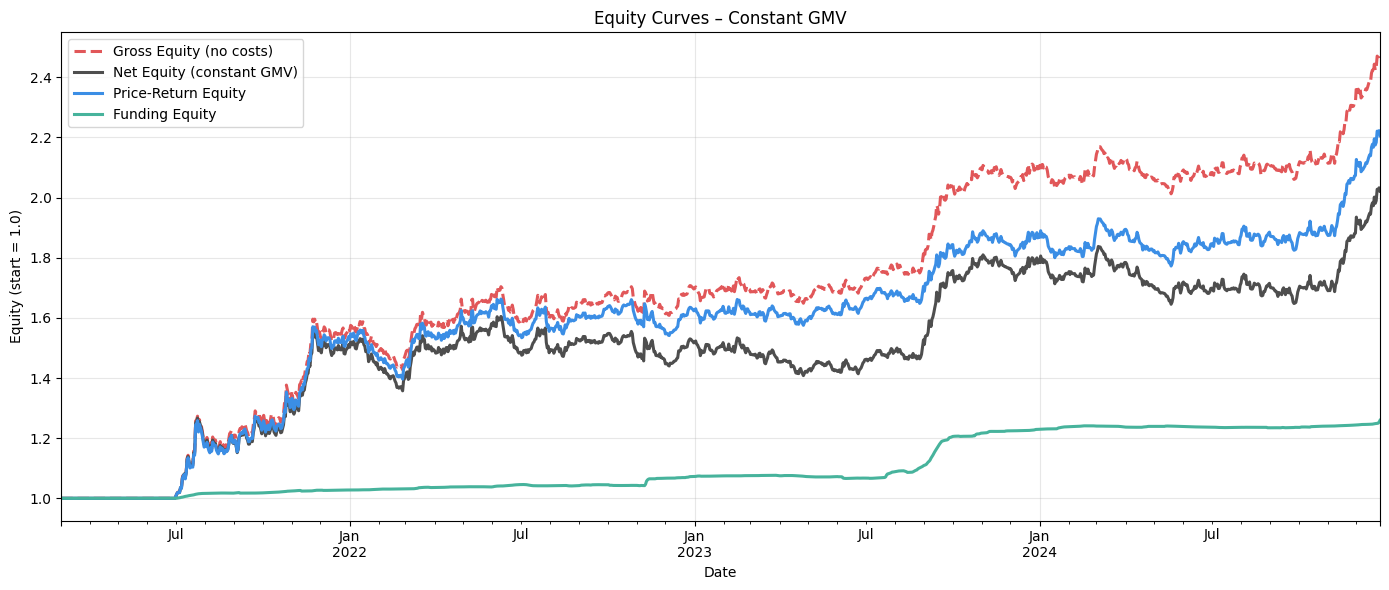

──────── Performance Summary ────────
CAGR:                           20.20%
Annualised volatility:           22.51%
Sharpe (ann.):                    1.19   95% CI [-0.12, 2.49]
Max drawdown:                  -19.69%
──────── Execution / Cost ───────────
Avg daily turnover:             21.17%
Avg holding period:               4.72 days
Average annual cost drag:       -1159.09 bp


In [45]:
sig, ret, fund, vol = pivot_data(universe_fc)
weights = compute_weights(sig, lag=True, lam_l2=portfolio_l2_norm, inertia=weight_inertia)
if vol_target_bool:
	weights = vol_target_weights(weights, ret,
								vol_target_ann=vol_target_ann,
								lookback=cov_lookback)

rtn_pnl, fnd_pnl, tot_pnl_post_cost, turn = backtest(weights, ret, fund, trading_cost_rate)

# filter all pnl to post 2024
if post_date:
	rtn_pnl = rtn_pnl[rtn_pnl.index > filter_date]
	fnd_pnl = fnd_pnl[fnd_pnl.index > filter_date]
	tot_pnl_post_cost = tot_pnl_post_cost[tot_pnl_post_cost.index > filter_date]
	turn = turn[turn.index > filter_date]

plot_results(rtn_pnl, fnd_pnl, tot_pnl_post_cost)
report_metrics(tot_pnl_post_cost, rtn_pnl, turn, trading_cost_rate)



In [34]:
universe_fc

,symbol,timestamp,open,high,low,close,volume,market_cap,fundingRate,oi,...,dollar_volume_slowed,dv_rank,market_cap_slowed,mc_rank,target,xs_bolmom_signal,xs_buy_volume_signal,liquidation_imbalance_signal,ls_ratio_signal,signal
0,1INCH,2021-03-02,4.01380,4.33040,3.98280,4.06790,23118130.0,5.754425e+08,0.000310,NaN,...,1.434543e+08,22,4.348451e+08,51,-0.036293,-1.190369,-0.827446,-0.615865,-6.6746,NaN
1,AAVE,2021-03-02,391.50900,420.14000,383.98900,396.55100,397737.7,4.643676e+09,0.000587,NaN,...,2.029343e+08,15,3.966496e+09,12,0.002074,-0.705525,1.253822,0.310665,-3.2535,NaN
2,ADA,2021-03-02,1.22288,1.26997,1.20786,1.21399,597127511.0,4.030911e+10,0.000300,NaN,...,1.033055e+09,5,2.124008e+10,3,-0.178554,1.046634,0.450584,0.000000,-5.2933,NaN
3,ALGO,2021-03-02,1.08380,1.23670,1.05880,1.18030,109791479.1,2.200547e+09,0.000508,NaN,...,8.549136e+07,35,1.402583e+09,30,-0.120185,-0.108500,-0.212251,0.257656,-6.2098,NaN
4,ALPHA,2021-03-02,1.51415,1.93326,1.48385,1.83116,80982423.0,2.423778e+08,0.000643,NaN,...,9.145484e+07,34,2.276547e+08,59,-0.216460,-0.320337,-0.555206,0.948379,-1.3607,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69795,UXLINK,2024-12-26,2.01900,2.06380,1.81560,1.87180,431687244.0,4.068323e+08,-0.089013,5.262542e+07,...,5.156866e+08,20,1.330892e+08,186,-0.237637,2.697729,0.976665,0.000000,-2.0111,0.008022
69796,WIF,2024-12-26,1.83910,1.93470,1.79640,1.82660,162866076.4,2.007983e+09,0.000300,1.349027e+08,...,7.431084e+08,13,2.725609e+09,33,0.003934,-1.626111,-0.110008,0.000000,-4.3735,-0.011340
69797,WLD,2024-12-26,2.18530,2.31080,2.15570,2.18530,113607066.0,NaN,0.000300,1.109670e+08,...,5.387185e+08,19,0.000000e+00,293,0.005935,-0.520626,-0.884358,0.000000,-5.2228,-0.006706
69798,XLM,2024-12-26,0.35453,0.36901,0.34433,0.34970,432827212.0,1.173600e+10,0.000298,4.427708e+07,...,5.957811e+08,16,1.004116e+10,12,0.203753,0.556079,1.450350,0.000000,-2.3546,-0.001871


In [35]:
universe_fc[universe_fc.symbol=='BTC']['forecast_meta'].plot()

KeyError: 'forecast_meta'

<Axes: >

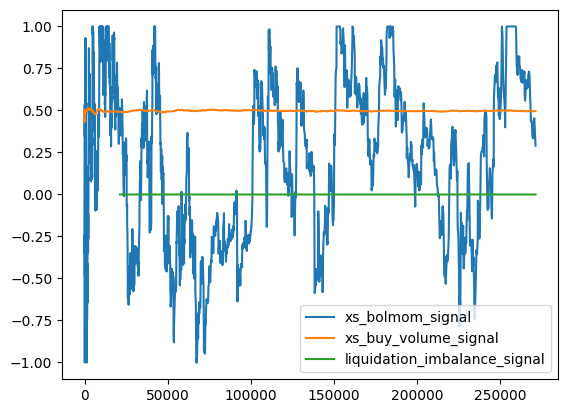

In [ ]:
with_signal[with_signal.symbol=='BTC'][['xs_bolmom_signal', 'xs_buy_volume_signal',
       'liquidation_imbalance_signal']].plot()

<Axes: xlabel='timestamp'>

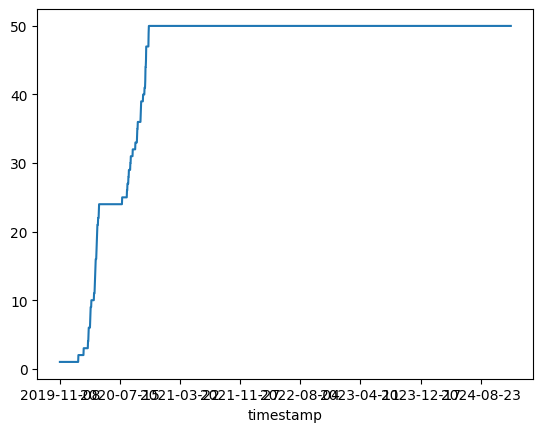

In [ ]:
universe.groupby('timestamp').agg('size').plot()

In [ ]:
# # dump to disk
# name = f"xs_bolmom_{EXCHANGE_NAME}_both"
# tot_pnl_post_cost.name = name
# tot_pnl_post_cost.to_csv(f'./data/backtests/{name}.csv')

# Compare to backtest

In [ ]:
tot_pnl_post_cost.index = pd.to_datetime(tot_pnl_post_cost.index)
monthly_log_returns = tot_pnl_post_cost.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns) - 1

plt.figure(figsize=(12, 6))
monthly_returns.plot(kind='bar')
plt.ylabel('Monthly Return')
plt.title('Monthly Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'tot_pnl_post_cost' is not defined

# Portfolio weights

<Axes: >

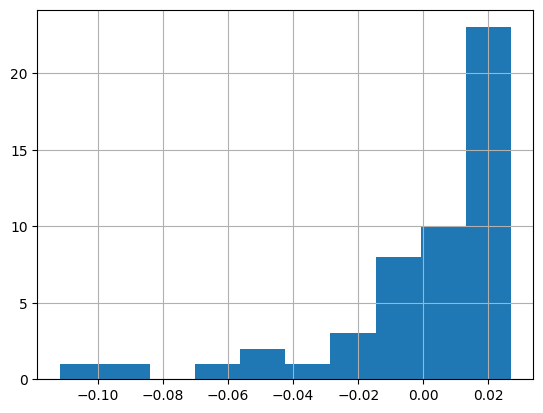

In [ ]:
last_weights = weights.iloc[-2]
last_weights = last_weights[last_weights.abs()>0]
last_weights.hist(bins=10)

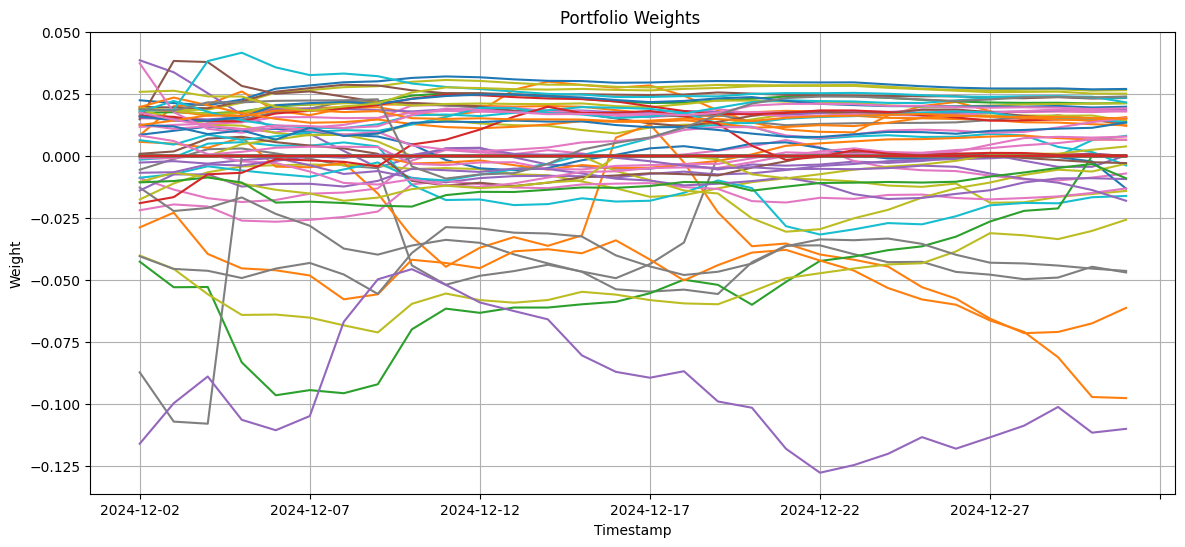

In [ ]:
weights.iloc[-30:].plot(figsize=(14, 6), title='Portfolio Weights ')
plt.legend().set_visible(False)
# plt.ylim(-0.075, 0.075)
plt.xlabel('Timestamp')
plt.ylabel('Weight')
plt.grid(True)
plt.show()


<Axes: title={'center': 'Signal'}, xlabel='timestamp'>

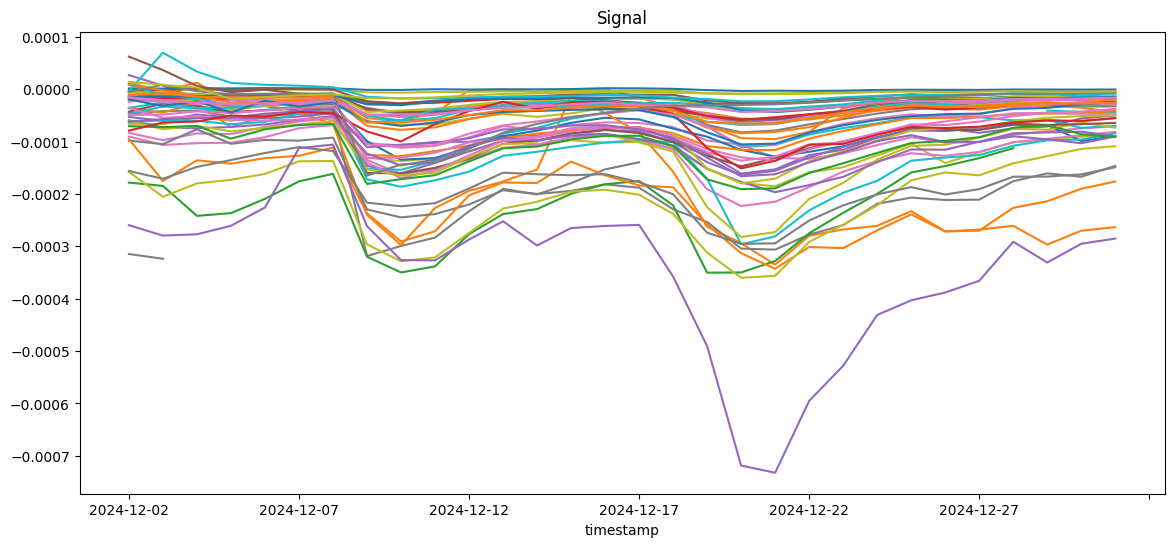

In [ ]:
sig.iloc[-30:].plot(figsize=(14, 6), title='Signal', legend=False)

<Axes: >

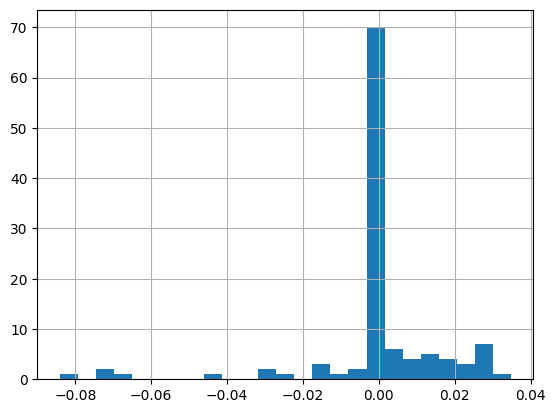

In [ ]:
weights.loc['2024-01-05'].dropna().sort_values().hist(bins=25)

# Universe churn

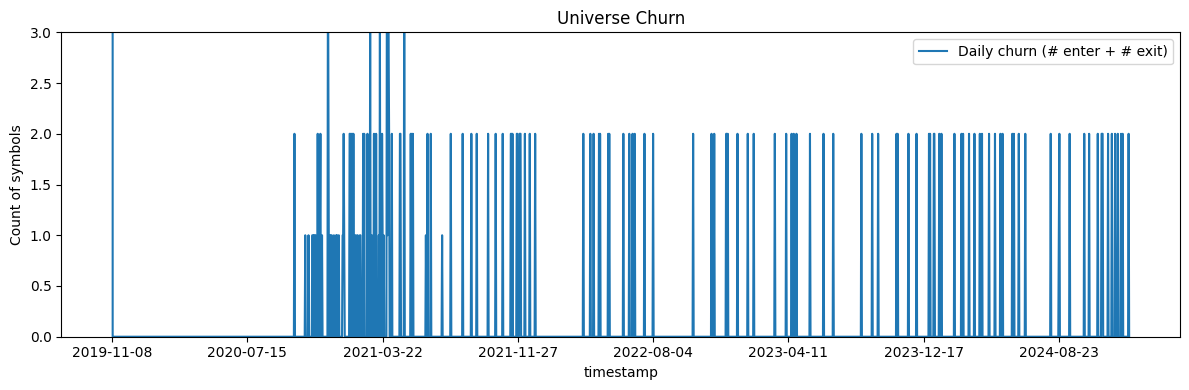

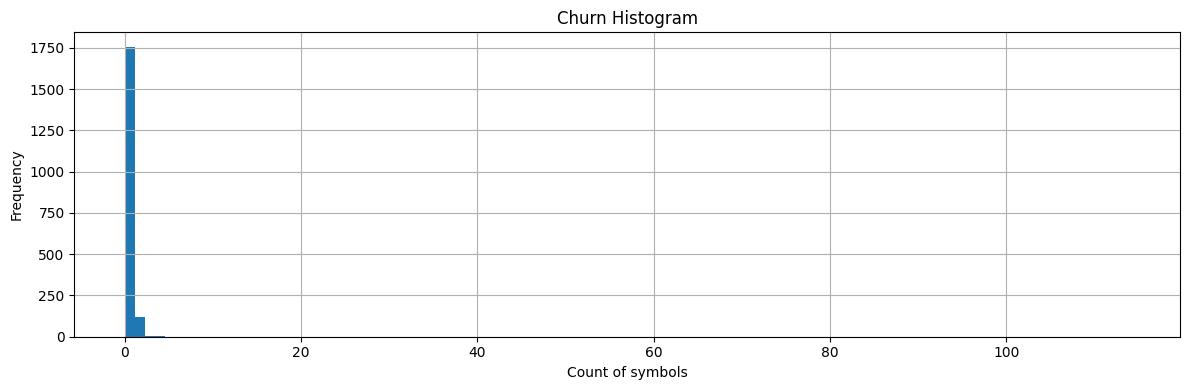

Avg daily churn: 0.22


In [ ]:
# boolean mask of who’s in the universe at each timestamp
in_univ = weights==0.0

# “previous” membership, with NaN → False
prev = in_univ.shift(1, fill_value=False)

# entries and exits
entered =  in_univ & ~prev
exited  = ~in_univ &  prev

# churn counts
entries = entered.sum(axis=1)
exits   = exited.sum(axis=1)
churn   = entries + exits

# plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.ylim(top=3)
churn.plot(label='Daily churn (# enter + # exit)')
plt.title('Universe Churn')
plt.ylabel('Count of symbols')
plt.legend()
plt.tight_layout()
plt.show()

# histogram of churn
plt.figure(figsize=(12,4))
churn.hist(bins=100)
plt.title('Churn Histogram')
plt.xlabel('Count of symbols')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print(f"Avg daily churn: {churn.mean():.2f}")


# Analytics

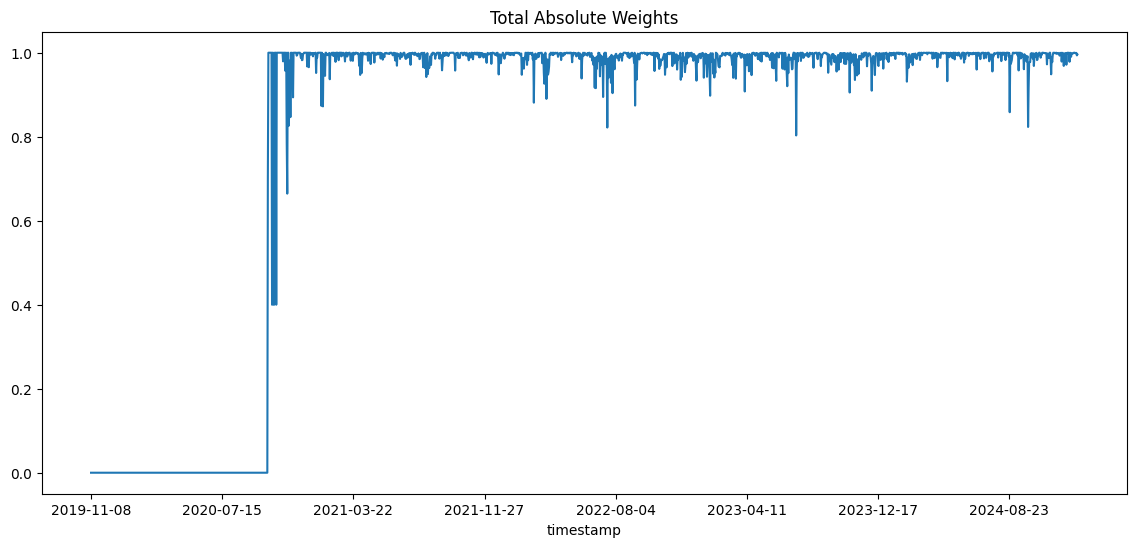

<Axes: title={'center': 'Total Weights'}, xlabel='timestamp'>

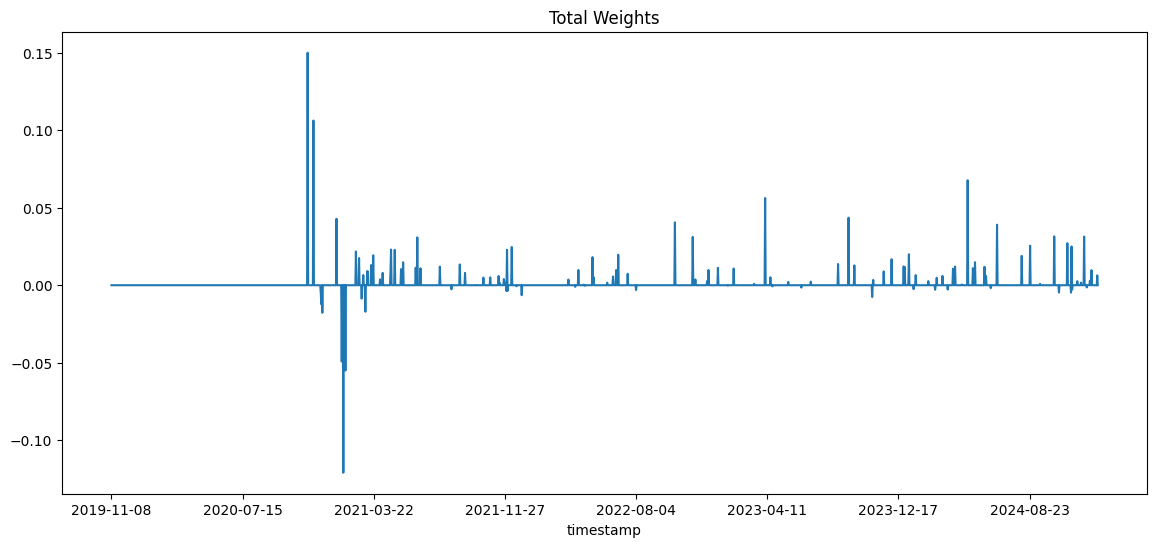

In [ ]:
weights.abs().sum(axis=1).plot(figsize=(14, 6), title='Total Absolute Weights')
plt.show()
weights.sum(axis=1).plot(figsize=(14, 6), title='Total Weights')